# Импортируем нужные нам библиотеки

In [1]:
from pandas import Series
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

# Импортируем данные и посмотрим на них поближе

In [2]:
data = pd.read_csv('train_demo.csv')

print(f'Data contains {len(data)} rows')

data.info()

Data contains 73799 rows
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   client_id         73799 non-null  int64 
 1   education         73492 non-null  object
 2   sex               73799 non-null  object
 3   age               73799 non-null  int64 
 4   car               73799 non-null  object
 5   car_type          73799 non-null  object
 6   decline_app_cnt   73799 non-null  int64 
 7   good_work         73799 non-null  int64 
 8   bki_request_cnt   73799 non-null  int64 
 9   home_address      73799 non-null  int64 
 10  work_address      73799 non-null  int64 
 11  income            73799 non-null  int64 
 12  foreign_passport  73799 non-null  object
 13  default           73799 non-null  int64 
dtypes: int64(9), object(5)
memory usage: 7.9+ MB


In [3]:
data.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
0,25905,SCH,M,62,Y,Y,0,0,1,1,2,18000,N,0
1,63161,SCH,F,59,N,N,0,0,3,2,3,19000,N,0
2,25887,SCH,M,25,Y,N,2,0,1,1,2,30000,Y,0
3,16222,SCH,F,53,N,N,0,0,2,2,3,10000,N,0
4,101655,GRD,M,48,N,N,0,1,1,2,3,30000,Y,0


<AxesSubplot:ylabel='default'>

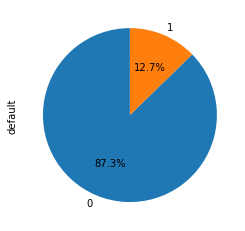

In [4]:
# Plot pie chart of default column values which contains two values 0 and 1
data.default.value_counts().plot.pie(autopct='%1.1f%%', startangle=90)


<AxesSubplot:ylabel='education'>

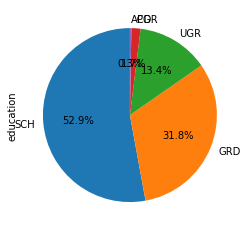

In [5]:
data.education.value_counts().plot.pie(autopct='%1.1f%%', startangle=90)

In [6]:
data.education.isna().value_counts()[1]

307

# Заполняем пропуски и преобразуем нужные нам колонки

In [7]:
# Пропущенные поля в колонке образования составляют меньше 0.5% от общего количество строк.
# Так что можем просто заполять их признаеом имеющим наибольшую долю.
data.loc[data.education.isna(), 'education'] = 'SCH'

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


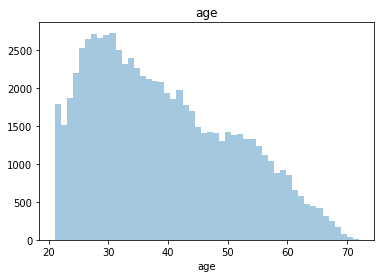

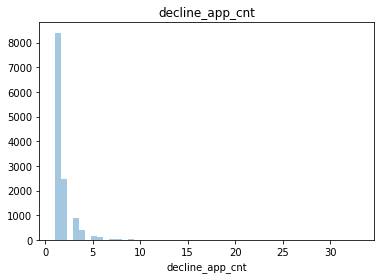

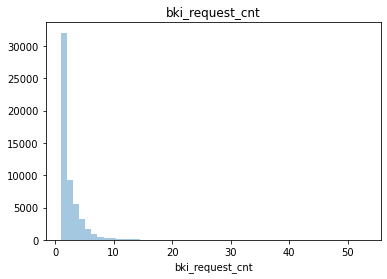

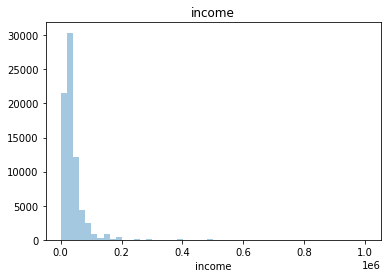

In [8]:
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']
for i in num_cols:
    plt.figure()
    sns.distplot(data[i][data[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

<AxesSubplot:>

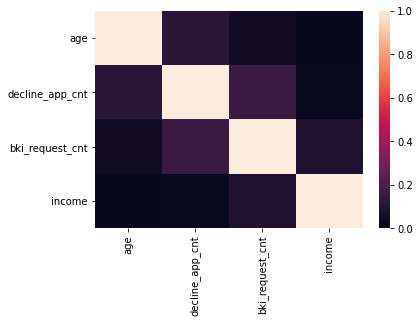

In [9]:
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1)


<AxesSubplot:>

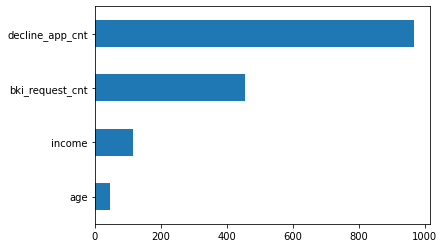

In [10]:
imp_num = pd.Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [11]:
label_encoder = LabelEncoder()
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport']

In [12]:
for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

In [13]:
cat_cols = ['home_address', 'work_address', 'education']

In [14]:
# Преобразуем поля образования целочисленным
data['education'] = label_encoder.fit_transform(data['education'])
data.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
0,25905,3,1,62,1,1,0,0,1,1,2,18000,0,0
1,63161,3,0,59,0,0,0,0,3,2,3,19000,0,0
2,25887,3,1,25,1,0,2,0,1,1,2,30000,1,0
3,16222,3,0,53,0,0,0,0,2,2,3,10000,0,0
4,101655,1,1,48,0,0,0,1,1,2,3,30000,1,0


<AxesSubplot:>

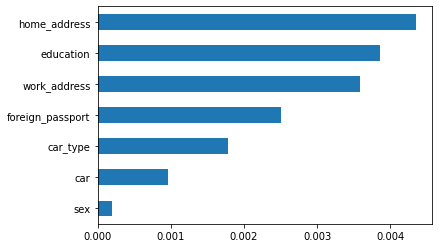

In [15]:
imp_cat = Series(mutual_info_classif(data[bin_cols + cat_cols], data['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')


In [16]:
X_cat = OneHotEncoder(sparse = False).fit_transform(data[cat_cols].values)

# Посмотрим на размер
X_cat.shape

(73799, 11)

In [17]:
X_num = StandardScaler().fit_transform(data[num_cols].values)

# Собираем преобразованные данные воедино

In [18]:
X = np.hstack([X_num, data[bin_cols].values, X_cat])
Y = data['default'].values

# Разделяем данные

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

# Обучаем модель

In [20]:
logReg = LogisticRegression(max_iter=1000)
logReg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

# Оценка результатов

In [21]:
probs = logReg.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)


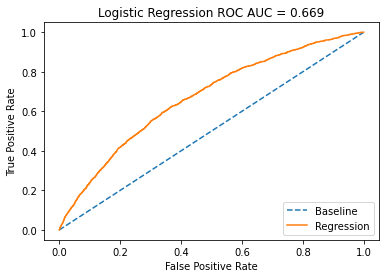

In [22]:
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [23]:
from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

# Если запускать модель с такими параметрами варнингов не выдает.
# Источники StackOverflow: https://bit.ly/2VSIsNu
# Documentation: https://bit.ly/3k1KnXQ
# model = LogisticRegression(max_iter=1000, solver='liblinear')
model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logisti

In [24]:
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])



Лучшее Penalty: l2
Лучшее C: 1.0
